In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import lu_factor, lu_solve

In [2]:
# Newton method in n dimensions implementation
def newton_method_nd(f,Jf,x0,tol,nmax,verb=False):

    # Initialize arrays and function value
    xn = x0; #initial guess
    rn = x0; #list of iterates
    Fn = f(xn); #function value vector
    n=0;
    nf=1; nJ=0; #function and Jacobian evals
    npn=1;

    if verb:
        print("|--n--|----xn----|---|f(xn)|---|");

    while npn>tol and n<=nmax:
        # compute n x n Jacobian matrix
        Jn = Jf(xn);
        nJ+=1;

        if verb:
            print("|--%d--|%1.7f|%1.12f|" %(n,np.linalg.norm(xn),np.linalg.norm(Fn)));

        # Newton step (we could check whether Jn is close to singular here)
        pn = -np.linalg.solve(Jn,Fn);
        xn = xn + pn;
        npn = np.linalg.norm(pn); #size of Newton step

        n+=1;
        rn = np.vstack((rn,xn));
        Fn = f(xn);
        nf+=1;

    r=xn;

    if verb:
        if np.linalg.norm(Fn)>tol:
            print("Newton method failed to converge, n=%d, |F(xn)|=%1.1e\n" % (nmax,np.linalg.norm(Fn)));
        else:
            print("Newton method converged, n=%d, |F(xn)|=%1.1e\n" % (n,np.linalg.norm(Fn)));

    return (r,rn,nf,nJ);


In [3]:
# Newton method in n dimensions implementation
def shaminski_method_nd(f,Jf,x0,tol,nmax,J_recalc, verb=False):

    # Initialize arrays and function value
    xn = x0; #initial guess
    rn = x0; #list of iterates
    Fn = f(xn); #function value vector
    n=0;
    nf=1; nJ=0; #function and Jacobian evals
    npn=1;

    if verb:
        print("|--n--|----xn----|---|f(xn)|---|");

    while npn>tol and n<=nmax:
        # compute n x n Jacobian matrix
        if(n%J_recalc == 0):
            Jn = Jf(xn);
            nJ+=1;

        if verb:
            print("|--%d--|%1.7f|%1.12f|" %(n,np.linalg.norm(xn),np.linalg.norm(Fn)));

        # Newton step (we could check whether Jn is close to singular here)
        pn = -np.linalg.solve(Jn,Fn);
        xn = xn + pn;
        npn = np.linalg.norm(pn); #size of Newton step

        n+=1;
        rn = np.vstack((rn,xn));
        Fn = f(xn);
        nf+=1;

    r=xn;

    if verb:
        if np.linalg.norm(Fn)>tol:
            print("Newton method failed to converge, n=%d, |F(xn)|=%1.1e\n" % (nmax,np.linalg.norm(Fn)));
        else:
            print("Newton method converged, n=%d, |F(xn)|=%1.1e\n" % (n,np.linalg.norm(Fn)));

    return (r,rn,nf,nJ);


In [14]:
def BK_solve(U, V, b, LU_piv):
    x = lu_solve(LU_piv, b)
    x = x + U.T@(V@b)
    return x

In [21]:
def broyden_method_nd(f,B0,x0,tol,nmax,Bmat='Id',verb=False):

    # Initialize arrays and function value
    d = x0.shape[0];
    xn = x0; #initial guess
    rn = x0; #list of iterates
    Fn = f(xn); #function value vector
    n=0;
    nf=1;
    npn=1;

    #####################################################################
    # Create functions to apply B0 or its inverse
    if Bmat=='fwd':
        #B0 is an approximation of Jf(x0)
        # Use pivoted LU factorization to solve systems for B0. Makes lusolve O(n^2)
        lu, piv = lu_factor(B0);
        luT, pivT = lu_factor(B0.T);

        def Bapp(x): return lu_solve((lu, piv), x); #np.linalg.solve(B0,x);
        def BTapp(x): return lu_solve((luT, pivT), x) #np.linalg.solve(B0.T,x);
    elif Bmat=='inv':
        #B0 is an approximation of the inverse of Jf(x0)
        def Bapp(x): return B0 @ x;
        def BTapp(x): return B0.T @ x;
    else:
        Bmat='Id';
        #default is the identity
        def Bapp(x): return x;
        def BTapp(x): return x;
    ####################################################################
    # Define function that applies Bapp(x)+Un*Vn.T*x depending on inputs
    def Inapp(Bapp,Bmat,Un,Vn,x):
        rk=Un.shape[0];

        if Bmat=='Id':
            y=x;
        else:
            y=Bapp(x);

        if rk>0:
            y=y+Un.T@(Vn@x);

        return y;
    #####################################################################

    # Initialize low rank matrices Un and Vn
    Un = np.zeros((0,d)); Vn=Un;

    if verb:
        print("|--n--|----xn----|---|f(xn)|---|");

    while npn>tol and n<=nmax:
        if verb:
            print("|--%d--|%1.7f|%1.12f|" % (n,np.linalg.norm(xn),np.linalg.norm(Fn)));

        #Broyden step xn = xn -B_n\Fn
        dn = -Inapp(Bapp,Bmat,Un,Vn,Fn);
        # Update xn
        xn = xn + dn;
        npn=np.linalg.norm(dn);

        ###########################################################
        ###########################################################
        # Update In using only the previous I_n-1
        #(this is equivalent to the explicit update formula)
        Fn1 = f(xn);
        dFn = Fn1-Fn;
        nf+=1;
        I0rn = Inapp(Bapp,Bmat,Un,Vn,dFn); #In^{-1}*(Fn+1 - Fn)
        un = dn - I0rn;                    #un = dn - In^{-1}*dFn
        cn = dn.T @ (I0rn);                # We divide un by dn^T In^{-1}*dFn
        # The end goal is to add the rank 1 u*v' update as the next columns of
        # Vn and Un, as is done in, say, the eigendecomposition
        Vn = np.vstack((Vn,Inapp(BTapp,Bmat,Vn,Un,dn)));
        Un = np.vstack((Un,(1/cn)*un));

        n+=1;
        Fn=Fn1;
        rn = np.vstack((rn,xn));

    r=xn;

    if verb:
        if npn>tol:
            print("Broyden method failed to converge, n=%d, |F(xn)|=%1.1e\n" % (nmax,np.linalg.norm(Fn)));
        else:
            print("Broyden method converged, n=%d, |F(xn)|=%1.1e\n" % (n,np.linalg.norm(Fn)));

    return(r,rn,nf)


In [22]:
def func_1(xvec):
    (x,y) = xvec
    f = x**2 + y**2 - 4
    g = np.exp(x) + y -1
    return np.array([f,g])

def Jfunc_1(xvec):
    (x,y) = xvec
    j11 = 2*x
    j12 = 2*y
    j21 = np.exp(x)
    j22 = 1
    return np.array([[j11,j12],[j21,j22]])

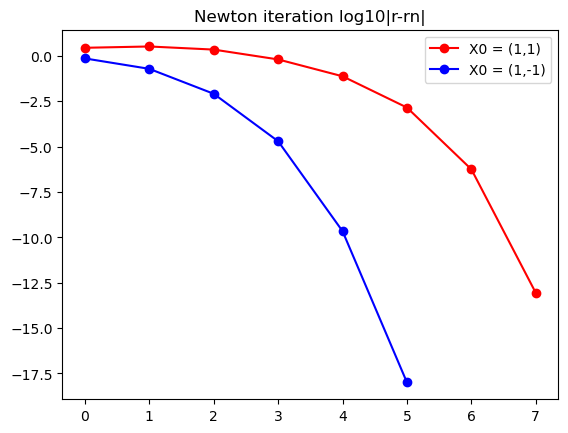

In [23]:
def driver1_newton():
    # Rootfinding example start. You are given F(x)=0.

    #First, we define F(x) and its Jacobian.

    # Apply Newton Method:
    tol=1e-13; nmax=500;
    
    x0_1 = np.array([1,1]);
    x0_2 = np.array([1,-1]);
    x0_3 = np.array([0,0]);
    
    (rN1,rnN1,nfN1,npn_arr1) = newton_method_nd(func_1,Jfunc_1,x0_1,tol,nmax);
    (rN2,rnN2,nfN2,npn_arr2) = newton_method_nd(func_1,Jfunc_1,x0_2,tol,nmax);
    # (rN3,rnN3,nfN3,npn_arr3) = newton_method_nd(func_1,Jfunc_1,x0_3,tol,nmax);

    # Plots and comparisons
    numN = rnN1.shape[0];
    errN = np.max(np.abs(rnN1[0:(numN-1)]-rN1),1);
    plt.plot(np.arange(numN-1),np.log10(errN+1e-18),'r-o',label='X0 = (1,1)');

    numN = rnN2.shape[0];
    errN = np.max(np.abs(rnN2[0:(numN-1)]-rN2),1);
    plt.plot(np.arange(numN-1),np.log10(errN+1e-18),'b-o',label='X0 = (1,-1)');

    
    plt.title('Newton iteration log10|r-rn|');
    plt.legend();
    plt.show()

driver1_newton()

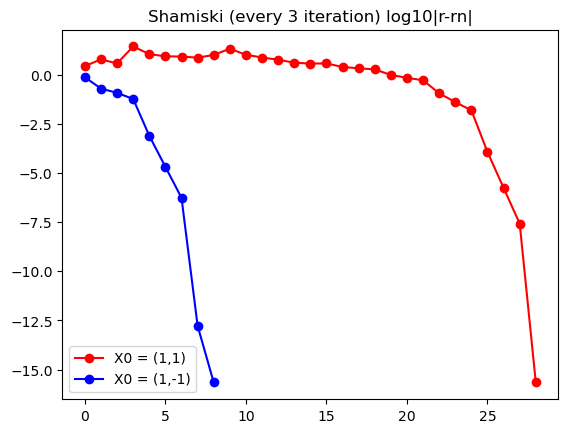

[ 1.00416874 -1.72963729]


In [24]:
def driver1_shaminski():
    # Rootfinding example start. You are given F(x)=0.

    #First, we define F(x) and its Jacobian.

    # Apply Newton Method:
    tol=1e-13; nmax=500;
    
    x0_1 = np.array([1,1]);
    x0_2 = np.array([1,-1]);
    x0_3 = np.array([0,0]);
    
    (rN1,rnN1,nfN1,npn_arr1) = shaminski_method_nd(func_1,Jfunc_1,x0_1,tol,nmax, 3);
    (rN2,rnN2,nfN2,npn_arr2) = shaminski_method_nd(func_1,Jfunc_1,x0_2,tol,nmax, 3);
    # (rN3,rnN3,nfN3,npn_arr3) = newton_method_nd(func_1,Jfunc_1,x0_3,tol,nmax);

    # Plots and comparisons
    numN = rnN1.shape[0];
    errN = np.max(np.abs(rnN1[0:(numN-1)]-rN1),1);
    plt.plot(np.arange(numN-1),np.log10(errN+1e-18),'r-o',label='X0 = (1,1)');

    numN = rnN2.shape[0];
    errN = np.max(np.abs(rnN2[0:(numN-1)]-rN2),1);
    plt.plot(np.arange(numN-1),np.log10(errN+1e-18),'b-o',label='X0 = (1,-1)');

    
    
    plt.title('Shamiski (every 3 iteration) log10|r-rn|');
    plt.legend();
    plt.show()

    print(rN1)

driver1_shaminski()

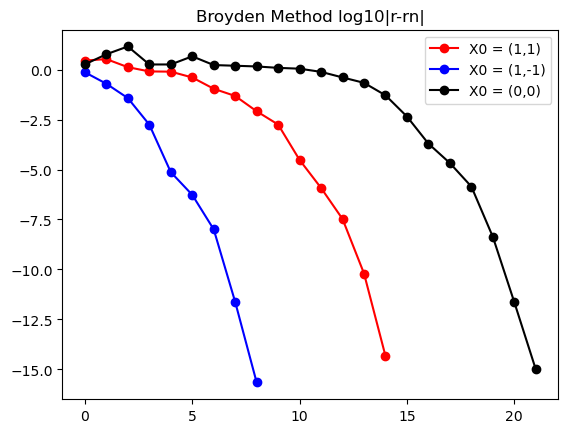

In [32]:
def driver1_broyden():
    # Rootfinding example start. You are given F(x)=0.

    #First, we define F(x) and its Jacobian.

    # Apply Newton Method:
    tol=1e-13; nmax=500;
    
    x0_1 = np.array([1,1]);
    x0_2 = np.array([1,-1]);
    x0_3 = np.array([0,0]);
    
    (rN1,rnN1,nfN1) = broyden_method_nd(func_1,Jfunc_1(x0_1),x0_1, tol,nmax, Bmat = "fwd");
    (rN2,rnN2,nfN2) = broyden_method_nd(func_1,Jfunc_1(x0_2),x0_2,tol,nmax, Bmat = "fwd");
    (rN3,rnN3,nfN3) = broyden_method_nd(func_1,np.identity(2),x0_3,tol,nmax);

    # Plots and comparisons
    numN = rnN1.shape[0];
    errN = np.max(np.abs(rnN1[0:(numN-1)]-rN1),1);
    plt.plot(np.arange(numN-1),np.log10(errN+1e-18),'r-o',label='X0 = (1,1)');

    numN = rnN2.shape[0];
    errN = np.max(np.abs(rnN2[0:(numN-1)]-rN2),1);
    plt.plot(np.arange(numN-1),np.log10(errN+1e-18),'b-o',label='X0 = (1,-1)');

    numN = rnN3.shape[0];
    errN = np.max(np.abs(rnN3[0:(numN-1)]-rN3),1);
    plt.plot(np.arange(numN-1),np.log10(errN+1e-18),'k-o',label='X0 = (0,0)');

    
    plt.title('Broyden Method log10|r-rn|');
    plt.legend();
    plt.show()

driver1_broyden()

In [39]:
def func_2(xvec):
    (x,y,z) = xvec
    f1 = x + np.cos(x*y*z) - 1
    f2 = (1 - x)**(1/4) + y + 0.05*z**2 - 0.15*z -1
    f3 = -x**2 - 0.1*y**2 + 0.01*y + z -1
    return np.array([f1, f2, f3])
def Jfunc_2(xvec):
    (x,y,z) = xvec
    j11 = 1
    j12 = -x*z*np.sin(x*y*z)
    j13 = -x*y*np.sin(x*y*z)

    j21 = -1/4*(1/(1-x)**(-3/4))
    j22 = 1
    j23 = 0.1*z - 0.15

    j31 = -2*x
    j32 = -0.2*y + 0.01
    j33 = 1

    J = np.array([[j11, j12, j13],[j21,j22,j23],[j31,j32,j33]])
    return J

In [84]:
import numpy as np

def gradient_descent_method(f, Jf, x0,tol, nmax,  alpha=0.1):
    x = np.array(x0, dtype=float)
    rn = x
    
    for _ in range(nmax):
        fx = f(x)
        if np.linalg.norm(fx) < tol:
            return x, rn
        
        Jx = Jf(x)
        
        
        # Compute update step
        delta_x = np.linalg.solve(Jx, fx)
        x = x - alpha * delta_x
        rn = np.vstack((rn ,x))
    
    raise ValueError("Gradient descent did not converge within the maximum number of iterations.")


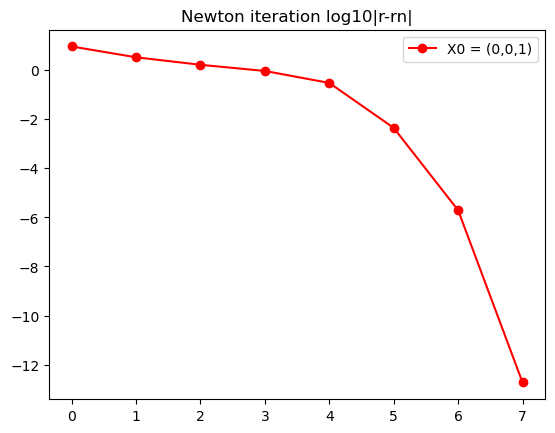

In [88]:
def driver2_newton():
    # Rootfinding example start. You are given F(x)=0.

    #First, we define F(x) and its Jacobian.

    # Apply Newton Method:
    tol=1e-6; nmax=500;
    
    x0_1 = np.array([-1,-9,1]);

    (rN1,rnN1,nfN1,aaa) = newton_method_nd(func_2,Jfunc_2,x0_1,tol,nmax);


    # Plots and comparisons
    numN = rnN1.shape[0];
    errN = np.max(np.abs(rnN1[0:(numN-1)]-rN1),1);
    plt.plot(np.arange(numN-1),np.log10(errN+1e-18),'r-o',label='X0 = (0,0,1)');
    
    plt.title('Newton iteration log10|r-rn|');
    plt.legend();
    plt.show()

driver2_newton()

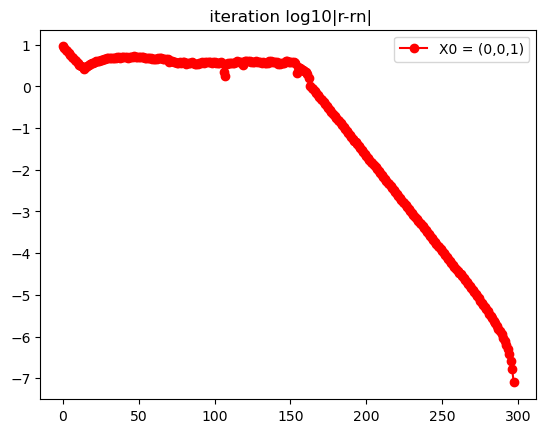

In [95]:
def driver2_gradescent():
    # Rootfinding example start. You are given F(x)=0.

    #First, we define F(x) and its Jacobian.

    # Apply Newton Method:
    tol=1e-6; nmax=500;
    
    x0_1 = np.array([-1,-9,1]);

    (rN1,rnN1) = gradient_descent_method(func_2,Jfunc_2,x0_1,tol,nmax);


    # Plots and comparisons
    numN = rnN1.shape[0];
    errN = np.max(np.abs(rnN1[0:(numN-1)]-rN1),1);
    plt.plot(np.arange(numN-1),np.log10(errN+1e-18),'r-o',label='X0 = (0,0,1)');
    
    plt.title(' iteration log10|r-rn|');
    plt.legend();
    plt.show()

driver2_gradescent()

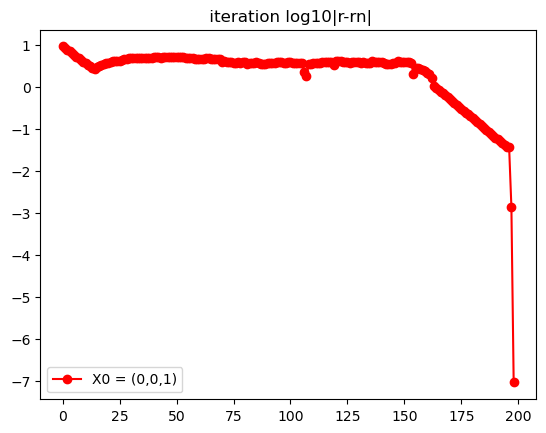

In [96]:
def driver2_hybrid():
    # Rootfinding example start. You are given F(x)=0.

    #First, we define F(x) and its Jacobian.

    # Apply Newton Method:
    tol=5*10**-2; nmax=500;
    
    
    x0_1 = np.array([-1,-9,1]);

    (rN_grad,rnN_grad) = gradient_descent_method(func_2,Jfunc_2,x0_1,tol,nmax);
    tol = 1e-6
    (rN1,rnN_newt,nfN1,aaa) = newton_method_nd(func_2,Jfunc_2,rN_grad,tol,nmax);

    rnN1 = np.vstack((rnN_grad,rnN_newt))

    # Plots and comparisons
    numN = rnN1.shape[0];
    errN = np.max(np.abs(rnN1[0:(numN-1)]-rN1),1);
    plt.plot(np.arange(numN-1),np.log10(errN+1e-18),'r-o',label='X0 = (0,0,1)');
    
    plt.title(' iteration log10|r-rn|');
    plt.legend();
    plt.show()

driver2_hybrid()